# Stock Portfolio Optimisation Tool Using Artificial Intelligence
## Thomas Lowe

In [1]:
%load_ext watermark
%load_ext tensorboard

In [2]:
#loads required packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Anaconda\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [31]:
def display_widget():
    print ("Please enter the dates you wish to retrieve stock data from")
    #Declare the widgets as global variables so they can be used in the next function
    global start_date_widget, end_date_widget
    start_date_widget = w.DatePicker(description='Start Date')
    end_date_widget = w.DatePicker(description='End Date')
    #Displays the widget datepicker that was just created
    display(start_date_widget, end_date_widget)

In [32]:
def date_from_widget():
    #converts the dates into strings
    start_date = str(start_date_widget.value)
    end_date = str(end_date_widget.value)
    return start_date, end_date

# Markowitz

In [33]:
tickers = ['FB','AAPL','TSLA','BP']
#Uses the tickers to get information from YahooFinancials package
yahoo_financials = yf(tickers)
display_widget()

Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [34]:
date_from_widget()
#Pulls the start_date, end_date variables from the date_from_widget function
start_date,end_date = date_from_widget()
print(start_date,end_date)

1990-01-01 2020-04-08


In [49]:
data = yahoo_financials.get_historical_price_data(start_date,end_date,'daily')

prices_df = pd.DataFrame({
    asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in tickers
})

prices_df.index.name="Formatted_Date"
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.head()

,FB,AAPL,TSLA,BP
Formatted_Date,,,,
2020-04-01,159.600006,240.910004,481.559998,24.370001
2020-04-02,158.190002,244.929993,454.470001,26.030001
2020-04-03,154.179993,241.410004,480.010010,24.719999
2020-04-06,165.550003,262.470001,516.239990,25.049999
2020-04-07,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Date')

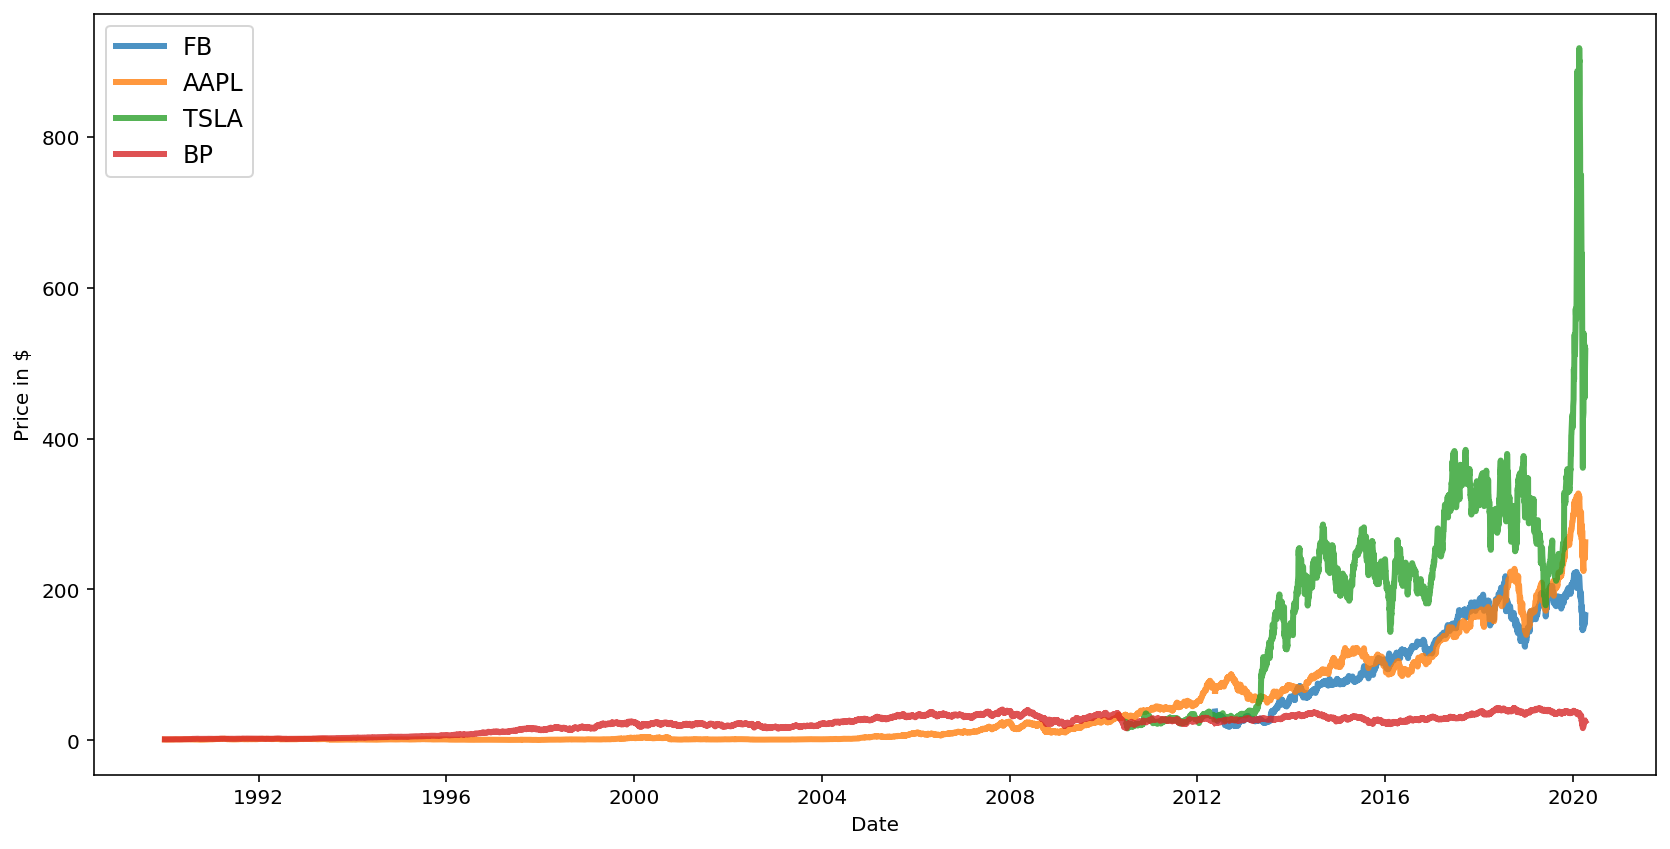

In [36]:
plt.figure(figsize=(14,7))
for c in prices_df.columns.values:
    plt.plot(prices_df.index,prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.xlabel('Date')

Text(0, 0.5, 'Daily Returns')

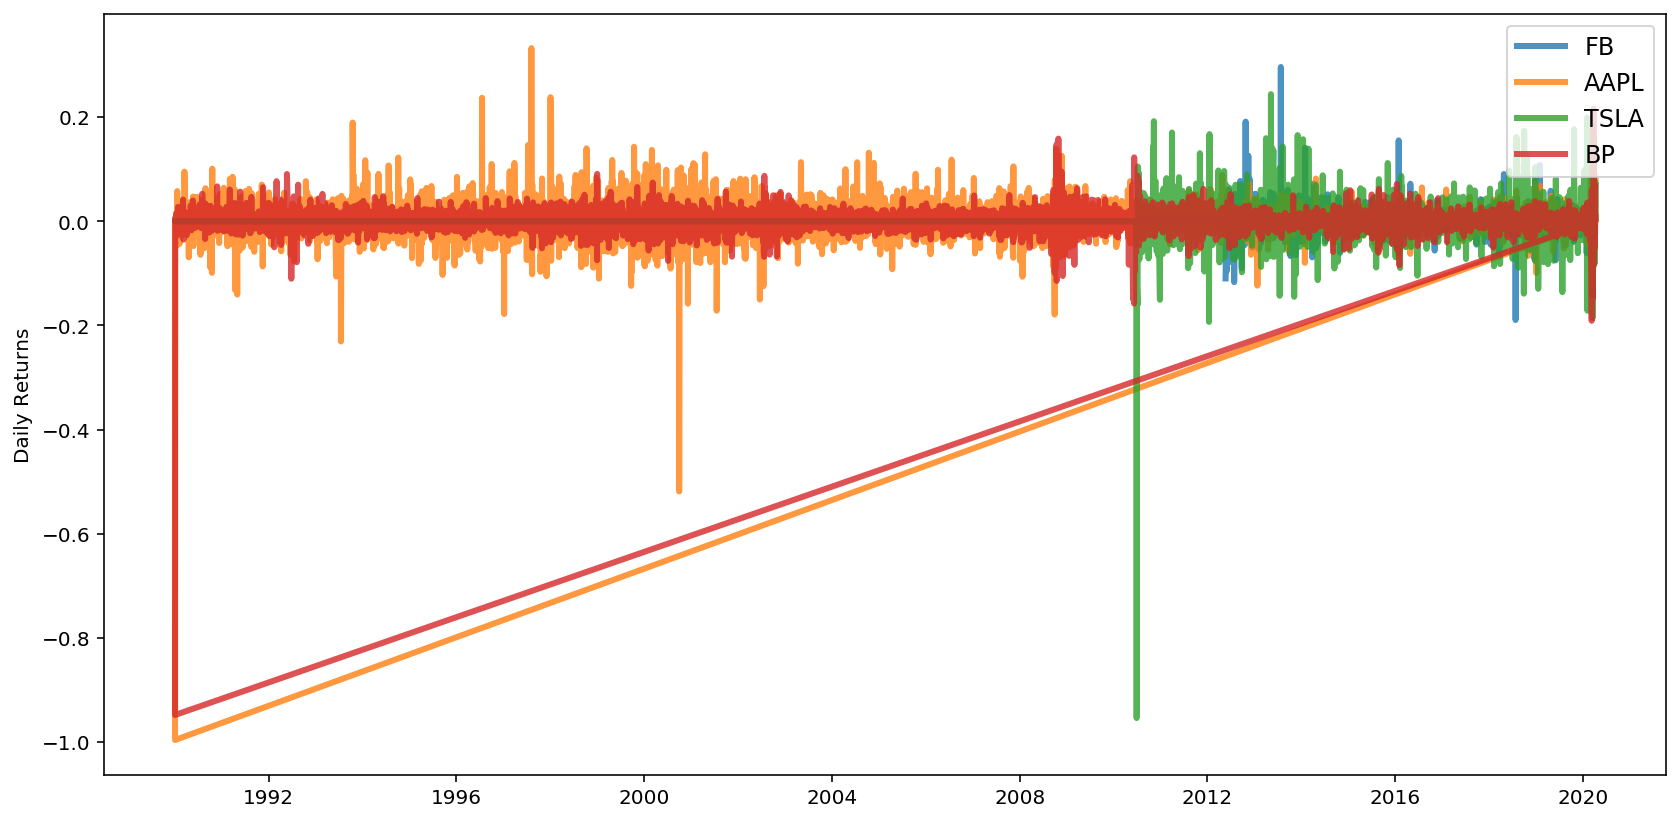

In [37]:
returns = prices_df.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right',fontsize=12)
plt.ylabel('Daily Returns')

In [38]:
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    #252 represents the number of trading days in a year
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [39]:
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [40]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]

    max_sharpe_allocation.allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print (prices_df)

    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.22


               FB   AAPL   TSLA    BP
allocation  33.24  35.09  22.99  8.69
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.16


               FB  AAPL   TSLA     BP
allocation  66.09   4.5  11.09  18.31
                       FB       AAPL       TSLA         BP
formatted_date                                            
2012-05-18      38.230000  65.770210  27.559999  23.393652
2012-05-21      34.029999  69.601997  28.770000  23.778296
2012-05-22      31.000000  69.067520  30.799999  23.866570
2012-05-23      32.000000  70.752777  31.020000  23.910711
2012-05-24      33.029999  70.102989  30.280001  24.106182
...                   ...        ...        ...        ...
2012-05-11            

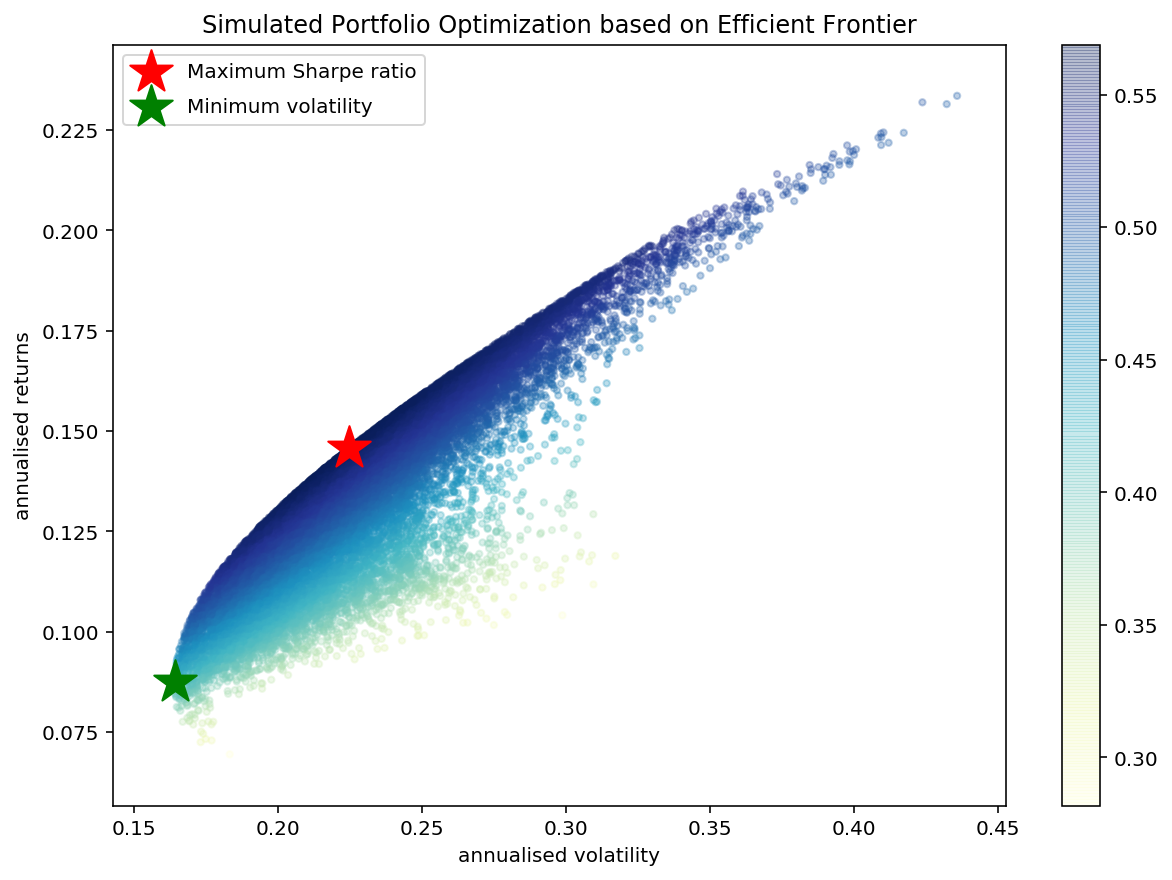

In [41]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

TypeError: display_simulated_ef_with_random() missing 4 required positional arguments: 'mean_returns', 'cov_matrix', 'num_portfolios', and 'risk_free_rate'

# Algorithm

In [42]:
display_widget()

Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [50]:
date_from_widget()
start_date,end_date = date_from_widget()
print(start_date,end_date)

2000-01-01 2020-01-01


In [51]:
ticker = input("Please enter a ticker here. I.e. BP.")
yahoo_finacials = yf(ticker)
data = yahoo_finacials.get_historical_price_data(start_date, end_date, "daily")

data

Please enter a ticker here. I.e. BP.MSFT


{'MSFT': {'eventsData': {'dividends': {'2014-11-18': {'amount': 0.31,
     'date': 1416321000,
     'formatted_date': '2014-11-18'},
    '2015-05-19': {'amount': 0.31,
     'date': 1432042200,
     'formatted_date': '2015-05-19'},
    '2018-11-14': {'amount': 0.46,
     'date': 1542205800,
     'formatted_date': '2018-11-14'},
    '2019-05-15': {'amount': 0.46,
     'date': 1557927000,
     'formatted_date': '2019-05-15'},
    '2019-02-20': {'amount': 0.46,
     'date': 1550673000,
     'formatted_date': '2019-02-20'},
    '2010-11-16': {'amount': 0.16,
     'date': 1289917800,
     'formatted_date': '2010-11-16'},
    '2011-05-17': {'amount': 0.16,
     'date': 1305639000,
     'formatted_date': '2011-05-17'},
    '2015-02-17': {'amount': 0.31,
     'date': 1424183400,
     'formatted_date': '2015-02-17'},
    '2015-08-18': {'amount': 0.31,
     'date': 1439904600,
     'formatted_date': '2015-08-18'},
    '2019-08-14': {'amount': 0.46,
     'date': 1565789400,
     'formatted_date': 

In [52]:
userInput_df = pdr.get_data_yahoo(ticker,
                          start_date,
                          end_date
                          )
userInput_df.head()
userInput_df=userInput_df.Close
userInput_df.head()

Date
2000-01-03    58.28125
2000-01-04    56.31250
2000-01-05    56.90625
2000-01-06    55.00000
2000-01-07    55.71875
Name: Close, dtype: float64

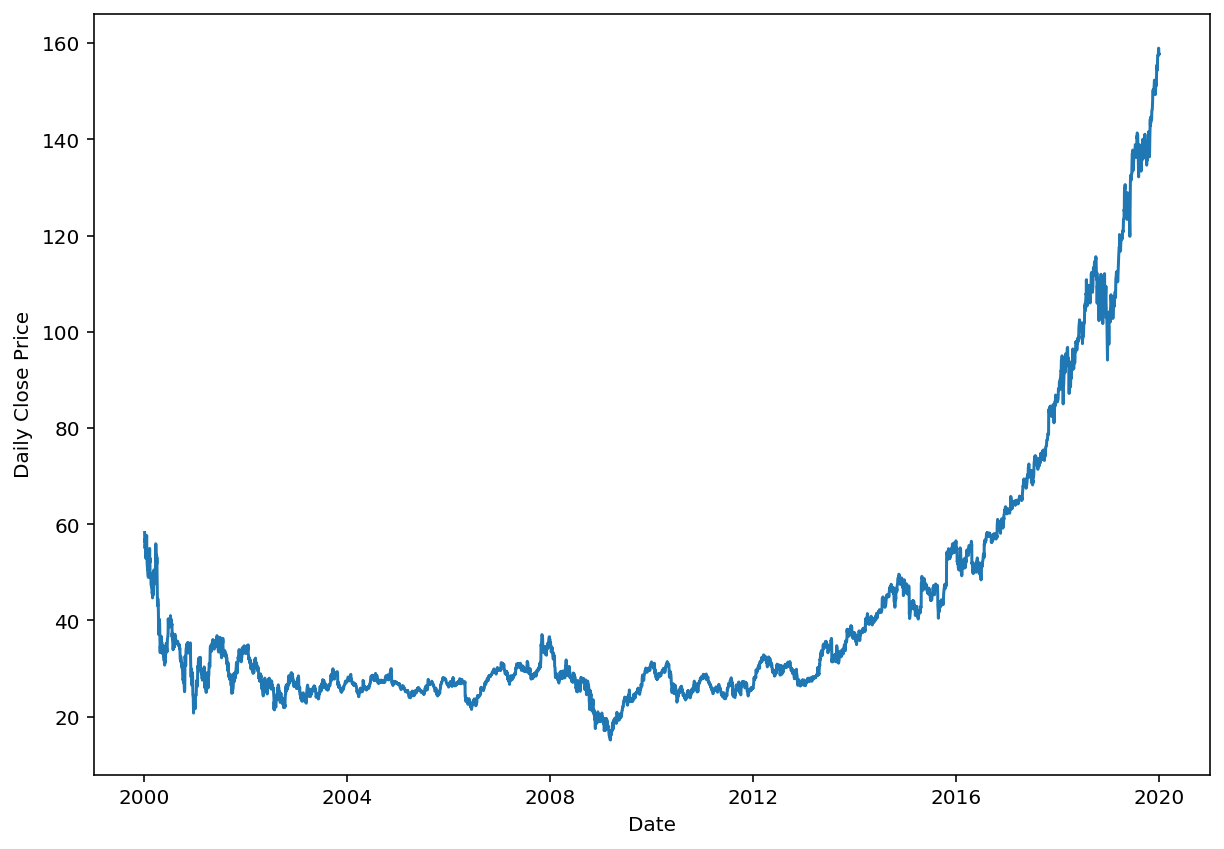

In [69]:
plt.figure(figsize=(10, 7))
plt.plot(userInput_df)
plt.ylabel('Daily Close Price')
plt.xlabel('Date')
plt.show()

In [54]:
X = userInput_df.values
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]

RMSE: 1.081


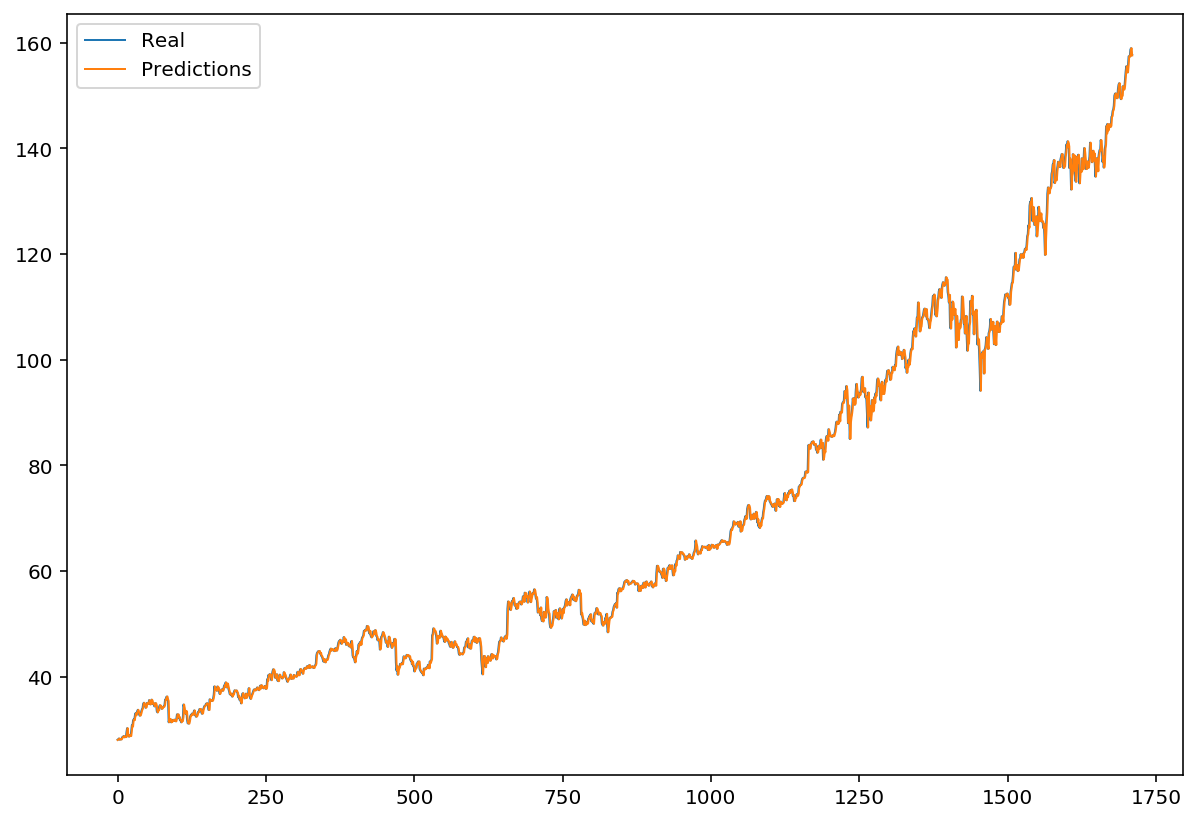

In [65]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])
#This is the percentage that the predictions deviate from the actual values
#Close rmse is to 0, the more accurate the model is
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(predictions, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()

# Prediction Method